# Introduction

When I started doing this analysis my main goal was getting experience. I'm still learning and trying to improve my skills, so there might be some areas can be improved. My main objectives on this project are:

*  **Explorating and visualising the data, trying to get some insights about our dataset**
*  **Getting data in better shape by feature engineering to help us in building better models**
*  **Building and tuning couple regression models to get some stable results on predicting house prices**

## Some Notes

* Please let me know if you have any recommendations or improvements, you can leave a comment at the end of this notebook.
* I appreciate any feedback since I'm trying to learn more! Please feel free to tell me how can I improve...
* And if you liked this one please don't forget to upvote!

### This is an early version of my notebook, I'll try to improve it whenever I can, there might be parts missings markdowns, explanations etc.

In [1]:
#Importing neccesary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode
from datetime import datetime

#

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import KFold, cross_val_score, learning_curve

#

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#

from scipy import stats
from scipy.stats import skew, boxcox_normmax, norm
from scipy.special import boxcox1p

import warnings
warnings.filterwarnings('ignore')
import string
import re

In [2]:
#Loading train and test datasets
train=pd.read_csv('/kaggle/input/titanic/train.csv')
test=pd.read_csv('/kaggle/input/titanic/test.csv')

#Displaying shape of both
print('Train set size:', train.shape)
print('Test set size:', test.shape)

Train set size: (891, 12)
Test set size: (418, 11)


In [3]:
#Looking at randomly selected rows
display(train.sample(5))
display(test.sample(5))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C
120,121,0,2,"Hickman, Mr. Stanley George",male,21.0,2,0,S.O.C. 14879,73.500,NaN,S
85,86,1,3,"Backstrom, Mrs. Karl Alfred (Maria Mathilda Gu...",female,33.0,3,0,3101278,15.850,NaN,S
107,108,1,3,"Moss, Mr. Albert Johan",male,NaN,0,0,312991,7.775,NaN,S
32,33,1,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.750,NaN,Q


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
150,1042,1,"Earnshaw, Mrs. Boulton (Olive Potter)",female,23.0,0,1,11767,83.1583,C54,C
85,977,3,"Khalil, Mr. Betros",male,NaN,1,0,2660,14.4542,NaN,C
228,1120,3,"Everett, Mr. Thomas James",male,40.5,0,0,C.A. 6212,15.1000,NaN,S
261,1153,3,"Nilsson, Mr. August Ferdinand",male,21.0,0,0,350410,7.8542,NaN,S
204,1096,2,"Andrew, Mr. Frank Thomas",male,25.0,0,0,C.A. 34050,10.5000,NaN,S


In [4]:
#Dropping not needed columns from both datasets
train.drop(['PassengerId'], axis=1, inplace=True)
test.drop(['PassengerId'], axis=1, inplace=True)

# First Inspection

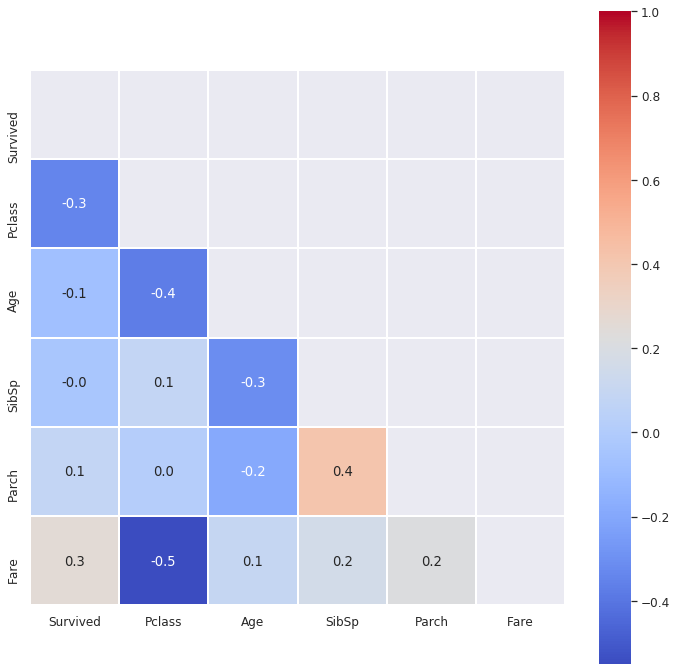

In [5]:
#Display numerical correlations between features on heatmap
sns.set(font_scale=1.1)
correlation_train = train.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1)

plt.show()

In [6]:
#Listing most related numerical features to target.
train_corr = train.corr().abs().unstack().sort_values(
    kind='quicksort', ascending=False).reset_index()
train_corr.rename(columns={
    'level_0': 'Feature A',
    'level_1': 'Feature B',
    0: 'Correlation Coefficient'
},
    inplace=True)
train_corr[(train_corr['Feature A'] == 'Survived')].style.background_gradient(
        cmap='summer_r')

,Feature A,Feature B,Correlation Coefficient
5,Survived,Survived,1.000000
12,Survived,Pclass,0.338481
16,Survived,Fare,0.257307
29,Survived,Parch,0.081629
31,Survived,Age,0.077221
33,Survived,SibSp,0.035322


In [7]:
#Backing up target variables and dropping them from train data
y = train.Survived.reset_index(drop=True)
train_features = train.drop(['Survived'], axis=1)
test_features = test

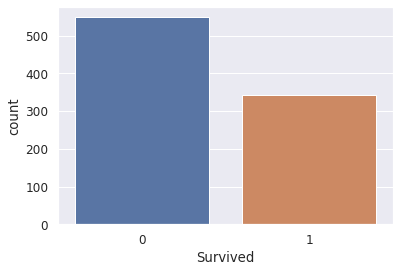

In [8]:
#Looking at targat variable distribution
sns.countplot(y)

In [9]:
#Merging train and test sets before engineering features for both.
features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape)

(1309, 10)


# Dealing with missing values

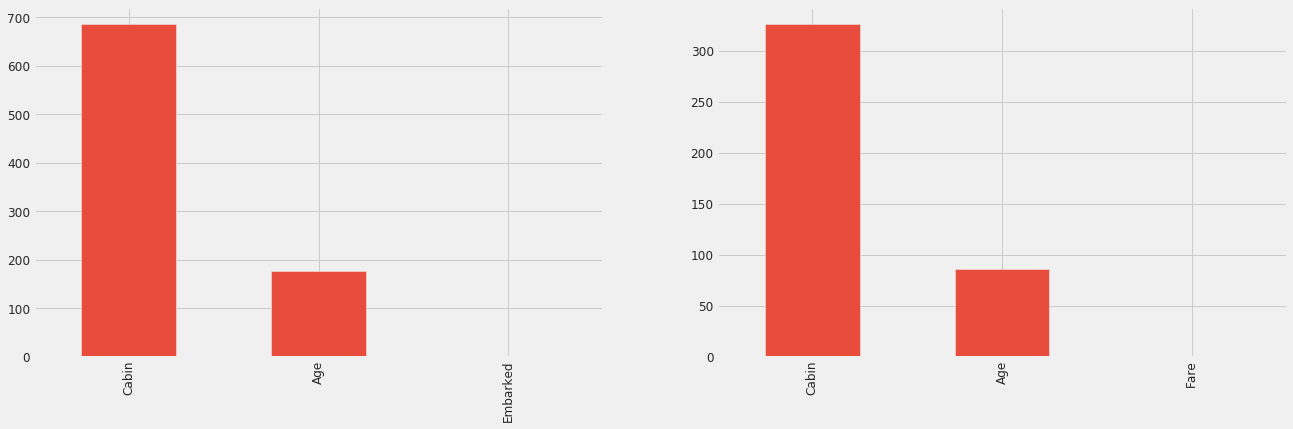

In [10]:
#Barplot of missing values on both sets.
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(ncols=2, figsize=(20,6))
missing_tr = train.isnull().sum()
missing_te = test.isnull().sum()
missing_tr = missing_tr[missing_tr > 0]
missing_te = missing_te[missing_te > 0]
missing_tr.sort_values(ascending=False).plot(kind='bar', color='#e74c3c', ax=ax[0])
missing_te.sort_values(ascending=False).plot(kind='bar', color='#e74c3c', ax=ax[1])

In [11]:
#Getting best out of missing cabin data
features['Docker_num'] = [cab[:1] if pd.notnull(cab) else "Unknown" for cab in features['Cabin']]
features['Has_cabin_informed'] = [1 if pd.notnull(cab) else 0 for cab in features['Cabin']]
features.drop(['Cabin'], axis=1, inplace=True)

In [12]:
#Looking general state of the data after filling one of the missing columns
display(features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pclass              1309 non-null   int64  
 1   Name                1309 non-null   object 
 2   Sex                 1309 non-null   object 
 3   Age                 1046 non-null   float64
 4   SibSp               1309 non-null   int64  
 5   Parch               1309 non-null   int64  
 6   Ticket              1309 non-null   object 
 7   Fare                1308 non-null   float64
 8   Embarked            1307 non-null   object 
 9   Docker_num          1309 non-null   object 
 10  Has_cabin_informed  1309 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


None

In [13]:
#Listing most related numerical features to Age for filling.
features_corr = features.corr().abs().unstack().sort_values(
    kind='quicksort', ascending=False).reset_index()
features_corr.rename(columns={
    'level_0': 'Feature A',
    'level_1': 'Feature B',
    0: 'Correlation Coefficient'
},
    inplace=True)
features_corr[(features_corr['Feature A'] == 'Age')].style.background_gradient(
        cmap='summer_r')

,Feature A,Feature B,Correlation Coefficient
2,Age,Age,1.000000
12,Age,Pclass,0.408106
17,Age,Has_cabin_informed,0.289740
18,Age,SibSp,0.243699
22,Age,Fare,0.178740
27,Age,Parch,0.150917


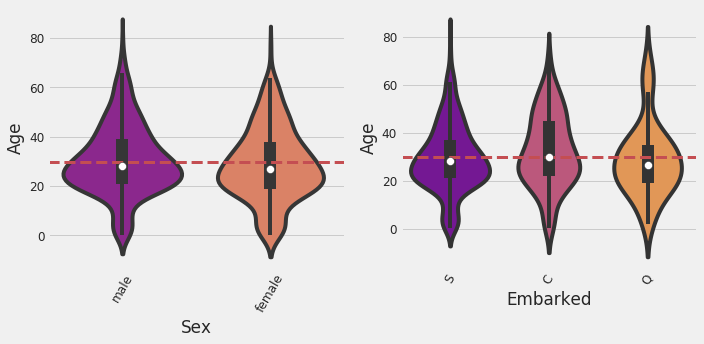

In [14]:
#Listing most related categorical features to Age for filling.
rel_col_age = ['Sex','Embarked']

#Plotting violin plots to see relationships

fig, axes =plt.subplots(1,2, figsize=(10,5))
axes = axes.flatten()

for ax, catplot in zip(axes, rel_col_age):
    sns.violinplot(x=catplot, y='Age', data=features, ax=ax, palette='plasma')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
    ax.axhline(train.Age.mean(),color='r',linestyle='--',linewidth=3)

plt.tight_layout()  
plt.show()

In [15]:
features['Age'] = features.groupby(['Has_cabin_informed', 'Pclass', 'SibSp'])['Age'].apply(lambda x: x.fillna(x.median()))

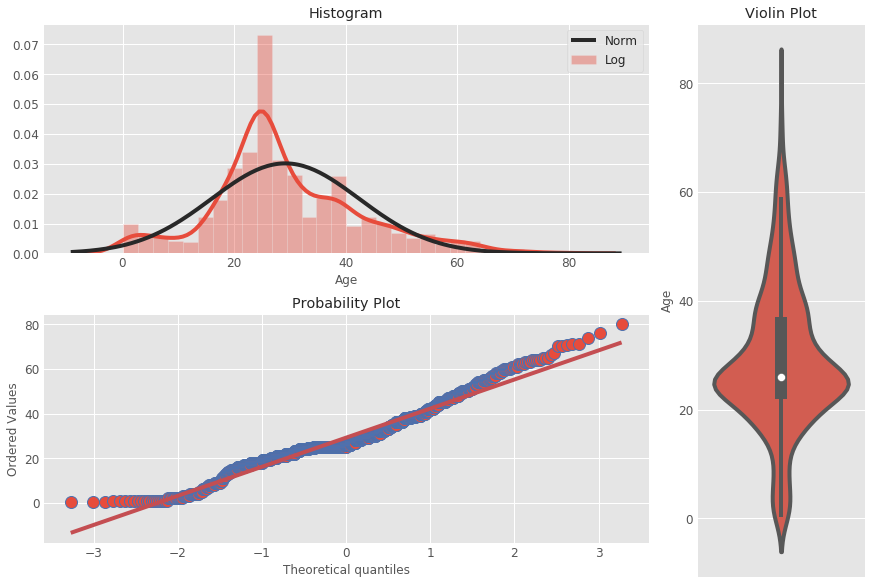

In [16]:
#Showing empirical target data set vs theororetical set after transforming target variables

def plot_3chart(df, feature):
    import matplotlib.gridspec as gridspec
    plt.style.use('ggplot')
    # Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    # creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title. 
    ax1.set_title('Histogram')
    # plot the histogram. 
    sns.distplot(df.loc[:,feature], hist=True,kde=True,fit=norm, ax = ax1,color='#e74c3c')
    ax1.legend(labels=['Norm','Log'])
    
    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title. 
    ax2.set_title('Probability Plot')
    # Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)
    ax2.get_lines()[0].set_markerfacecolor('#e74c3c')
    ax2.get_lines()[0].set_markersize(12.0)
    

    # Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title. 
    ax3.set_title('Violin Plot')
    # Plotting the box plot. 
    sns.violinplot(df.loc[:,feature], orient='v', ax = ax3,color='#e74c3c');
    
plot_3chart(features, 'Age')

In [17]:
#Filling missing embarked data with most frequent ones
features['Embarked'].fillna(features['Embarked'].mode()[0], inplace=True)

In [18]:
#Listing most related numerical features to Fare for filling.
features_corr[(features_corr['Feature A'] == 'Fare')].style.background_gradient(
        cmap='summer_r')

,Feature A,Feature B,Correlation Coefficient
1,Fare,Fare,1.000000
9,Fare,Pclass,0.558629
10,Fare,Has_cabin_informed,0.507253
21,Fare,Parch,0.221539
23,Fare,Age,0.178740
25,Fare,SibSp,0.160238


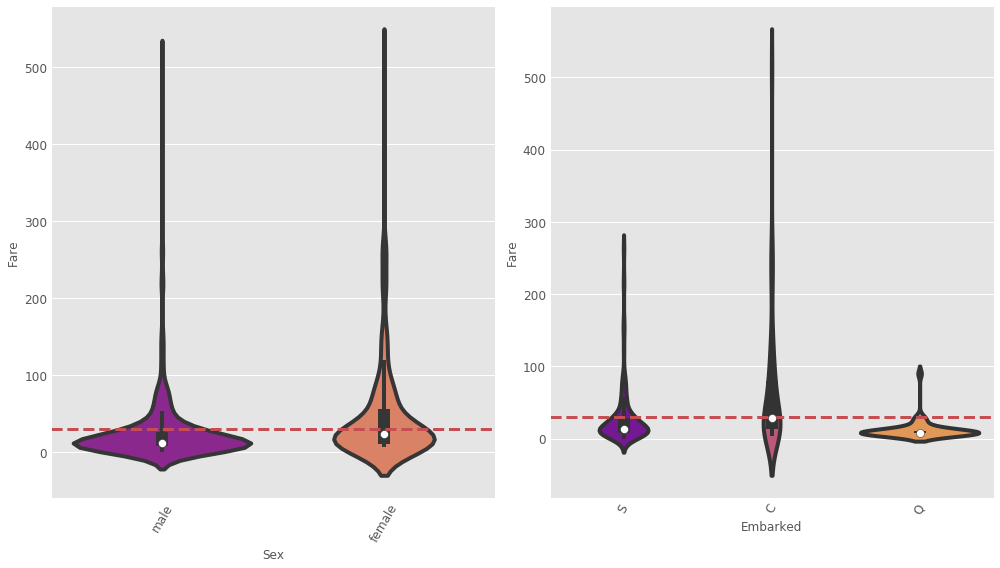

In [19]:
#Listing most related categorical features to Fare for filling.
rel_col_age = ['Sex','Embarked']

#Plotting violin plots to see relationships

fig, axes =plt.subplots(1,2, figsize=(14,8))
axes = axes.flatten()

for ax, catplot in zip(axes, rel_col_age):
    sns.violinplot(x=catplot, y='Fare', data=features, ax=ax, palette='plasma')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
    ax.axhline(train.Age.mean(),color='r',linestyle='--',linewidth=3)

plt.tight_layout()  
plt.show()

In [20]:
#Filling Fare with related data
features['Fare'] = features.groupby(['Pclass', 'Sex', 'Has_cabin_informed'])['Fare'].apply(lambda x: x.fillna(x.median()))

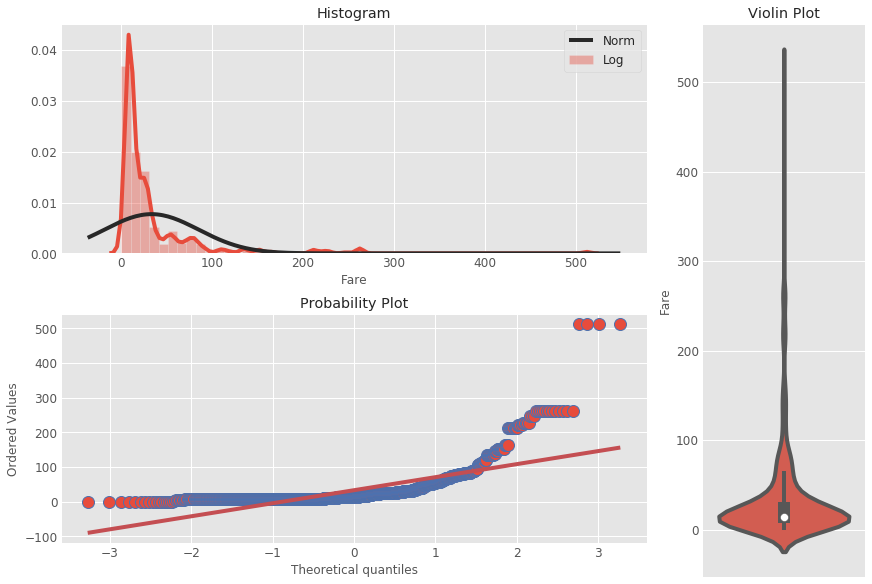

In [21]:
#Displaying distribution of Fare
plot_3chart(features, 'Fare')

In [22]:
print(f'Missing data count: {features.isna().sum().sum()}')

Missing data count: 0


# Feature Engineering

In [23]:
#Extracting titles out of names
features['Title'] = features['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
features['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Ms                2
Mlle              2
the Countess      1
Don               1
Sir               1
Lady              1
Mme               1
Dona              1
Jonkheer          1
Capt              1
Name: Title, dtype: int64

In [24]:
#Grouping similar groups and outliers in same groups
features['Title'] = features['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
features['Title'] = features['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

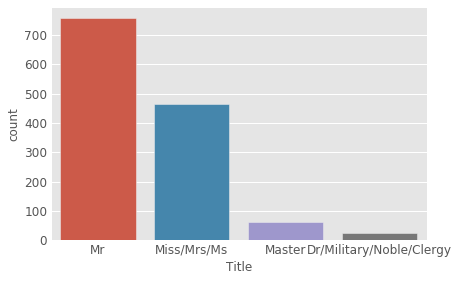

In [25]:
#Displaying title groups
sns.countplot(features['Title'])

In [26]:
#Creating new feature called FamilySize by merging related columns
features['FamilySize'] = features['SibSp'] + features['Parch'] + 1
features['FamilySize'].value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: FamilySize, dtype: int64

In [27]:
#Grouping family sizes
features['FamilySize'] = features['FamilySize'].replace(1, 'Single')
features['FamilySize'] = features['FamilySize'].replace(2, 'SmallF')
features['FamilySize'] = features['FamilySize'].replace([3,4], 'MedF')
features['FamilySize'] = features['FamilySize'].replace([5,6,7,8,11], 'LargeF')

In [28]:
#Extracting prefix from tickets
Ticket = []
for i in list(features.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("M")
        
features["Ticket"] = Ticket
features["Ticket"].sample(10)

1176         A5
1076          M
477           M
373          PC
833           M
575           M
578           M
1276          M
1050    SOTONOQ
1074          M
Name: Ticket, dtype: object

In [29]:
#Ranging and grouping Ages
bins = [0, 2, 18, 35, 65, np.inf]
names = ['less2', '2-18', '18-35', '35-65', '65plus']

features['Age'] = pd.cut(features['Age'], bins, labels=names)


# Grouping Age and Fare

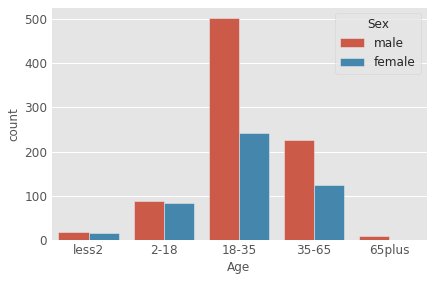

In [30]:
#Checking our Age data after grouping
sns.countplot(features['Age'], hue=features['Sex'])
plt.show()

In [31]:
#Ranging and grouping Fare using historical data
bins = [0, 15, 60, 150, np.inf]
names = ['Third Class', 'Second Class', 'First Class (berth)', 'First Class (parlor suite)']

features['Fare'] = pd.cut(features['Fare'], bins, labels=names)

features['Fare'].value_counts()


Third Class                   657
Second Class                  451
First Class (berth)           133
First Class (parlor suite)     51
Name: Fare, dtype: int64

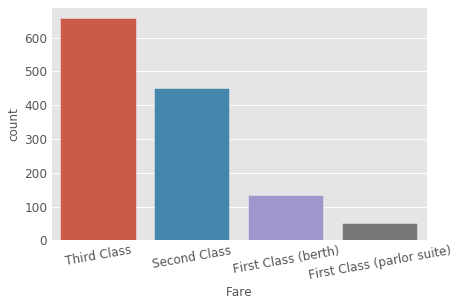

In [32]:
#Checking our Age data after grouping
sns.countplot(features['Fare'])
plt.xticks(rotation=10)
plt.show()

# Processing Data

In [33]:
#Getting dummies for categorical data to use them in models
features=pd.get_dummies(features, columns=['Pclass','Embarked', 'Title', 'Age','Docker_num', 'Fare','Sex', 'FamilySize', 'Ticket'])

In [34]:
#Dropping not needed columns
features.drop(['Name', 'SibSp'], axis=1, inplace=True)

In [35]:
#Splitting train test data for modelling
X_train = features.iloc[:len(y), :]
X_test = features.iloc[len(X_train):, :]
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 73)
y_train shape: (891,)
X_test shape: (418, 73)


# Modelling

In [36]:
#Defining cross val set
nfolds = 10
kf = KFold(nfolds, shuffle=True, random_state=42)


# rmsle_cv
def acc_cv(model, trainx, trainy):
    rmse = cross_val_score(model,
                                          trainx.values,
                                          trainy,
                                          scoring='accuracy',
                                          cv=kf,
                                          n_jobs=-1)
    return (rmse)

In [37]:
#Models:

randforest = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=42,
                                           n_jobs=-1,
                                           verbose=0)

lbm = LGBMClassifier(
        learning_rate=0.00358,
        n_estimators=3900,
        min_child_weight=0,
        colsample_bytree=0.7571,
        max_depth=2,
        subsample=0.45170,
        random_state=42,
        n_jobs=-1
        
    )

xgb = XGBClassifier(n_estimators = 3300,
                              min_child_weight = 0,
                              learning_rate = 0.00316,
                              max_depth = 2,
                              subsample=0.66246,
                              nthread=-1,
                              seed=42,
                              colsample_bytree=0.4011,
                              scale_pos_weight=1,
                              )

#Stacking models
votingC = VotingClassifier(estimators=[('xgb', xgb), ('randforest', randforest),
('lbm', lbm)], voting='soft', n_jobs=-1)

votingCl = votingC.fit(X_train, y)

In [38]:
mods = [randforest,lbm,xgb, votingCl]

# Model Results

In [39]:
#Getting model performances
mod_name = []
rms = []
rmstd = []

#executing models
for i in mods:
    score = acc_cv(i, X_train, y)
    mod_name.append(type(i).__name__)
    rms.append(score.mean())
    rmstd.append(score.std())

#creating a data frame out of crossval results
model_df = pd.DataFrame(list(zip(mod_name, rms, rmstd)),
                        columns=['Model', 'Accuracy', 'Acc_Std'])

display(
    model_df.sort_values(by='Accuracy', ascending=False).reset_index(
        drop=True).style.background_gradient(cmap='summer_r'))

,Model,Accuracy,Acc_Std
0,XGBClassifier,0.833895,0.028769
1,VotingClassifier,0.831648,0.027066
2,LGBMClassifier,0.830524,0.033133
3,RandomForestClassifier,0.822647,0.040540


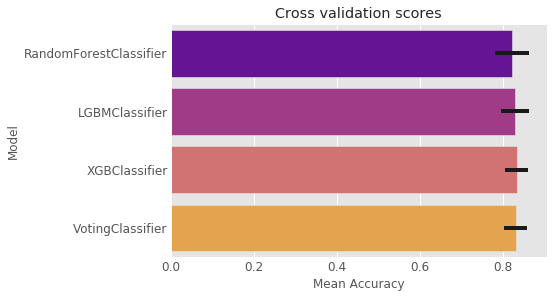

In [40]:
#Plotting model performances
g = sns.barplot("Accuracy","Model",data = model_df, palette="plasma",orient = "h",**{'xerr':model_df['Acc_Std']})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

# AUC Scoring

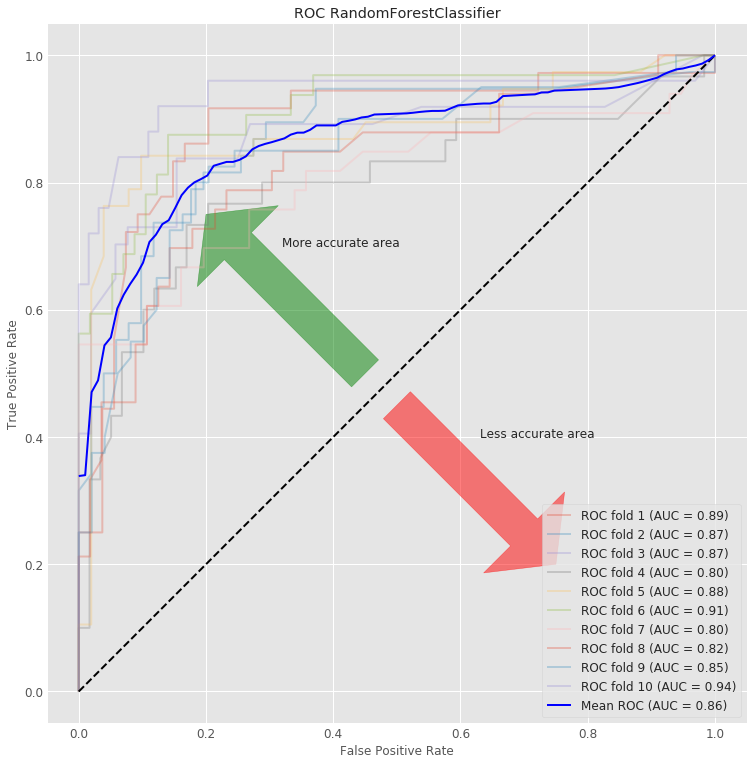

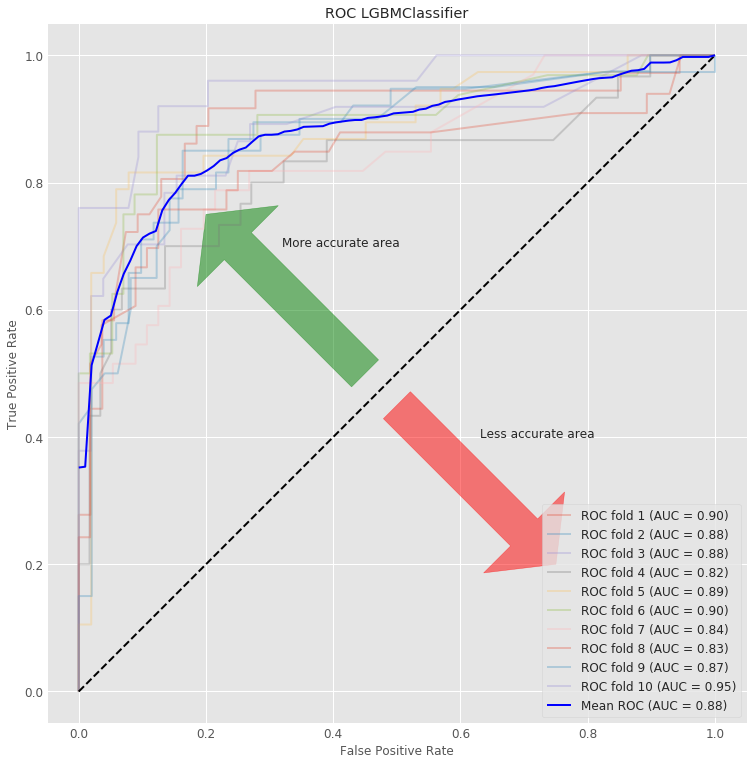

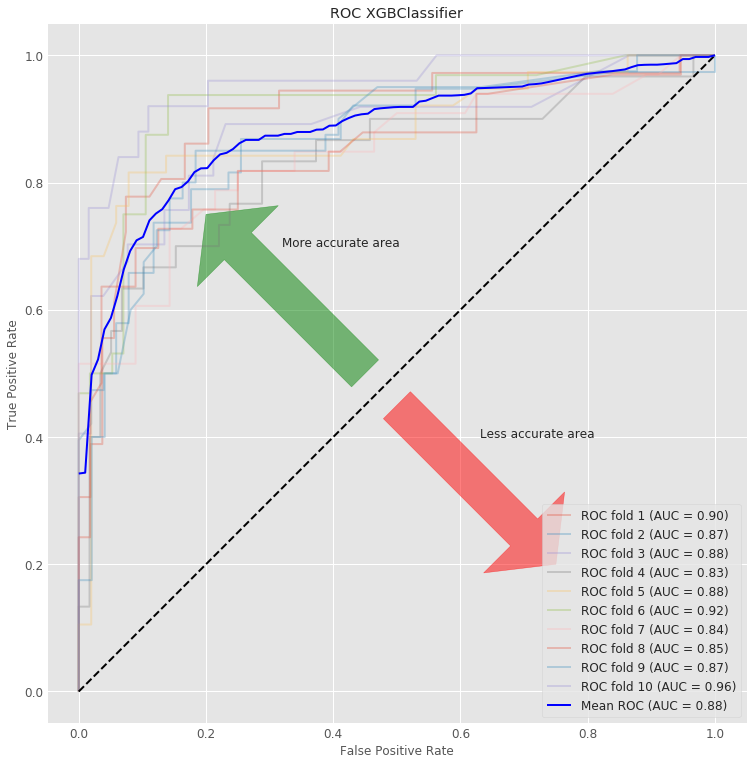

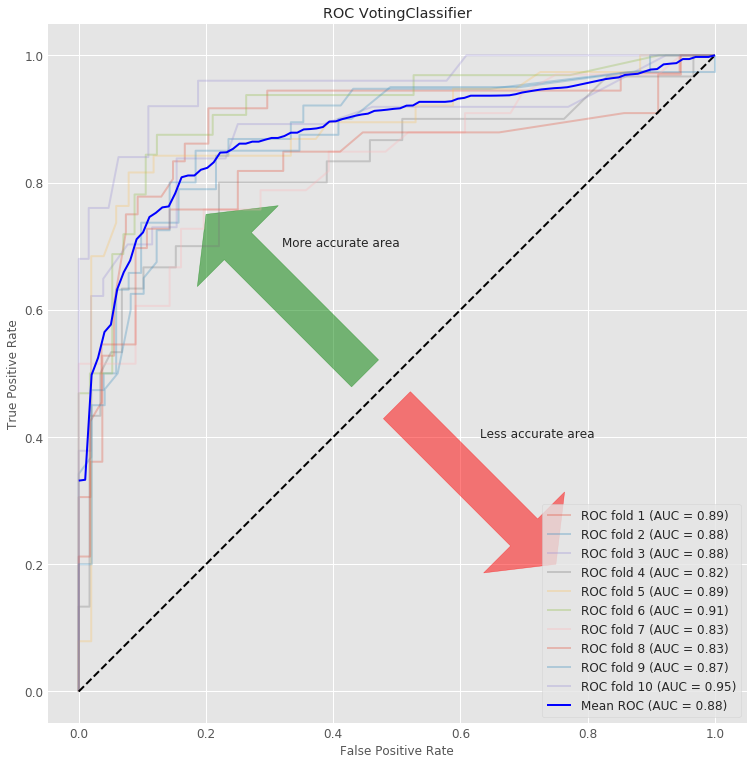

In [41]:
import matplotlib.patches as patches
from scipy import interp

for mod in mods:
    # plot arrows
    fig1 = plt.figure(figsize=[12,12])
    ax1 = fig1.add_subplot(111,aspect = 'equal')
    ax1.add_patch(
        patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
        )
    ax1.add_patch(
        patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
        )

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    for train,test in kf.split(X_train,y):
        prediction = mod.fit(X_train.iloc[train],y.iloc[train]).predict_proba(X_train.iloc[test])
        fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'ROC fold {i} (AUC = {roc_auc:.2f})')
        i= i+1

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=f'Mean ROC (AUC = {mean_auc:.2f})',lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC {type(mod).__name__}')
    plt.legend(loc="lower right")
    plt.text(0.32,0.7,'More accurate area',fontsize = 12)
    plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
    plt.show()

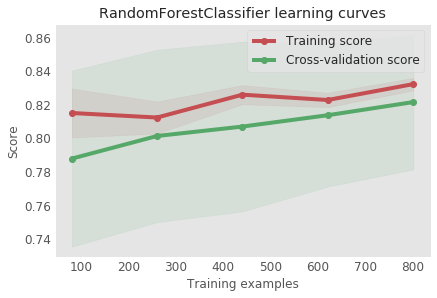

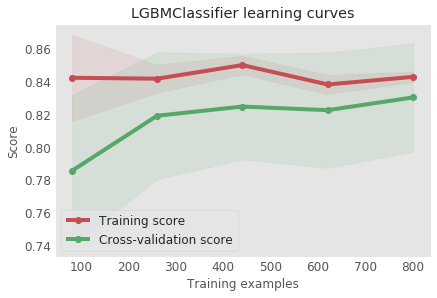

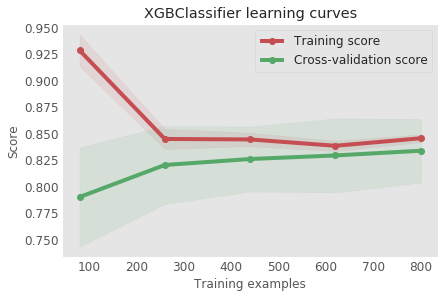

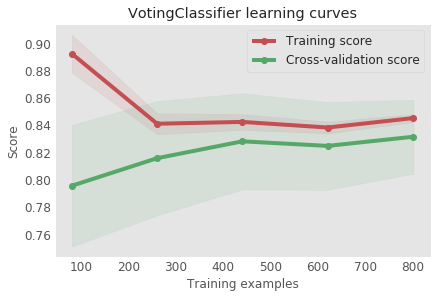

In [42]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

for mod in mods:
    g=plot_learning_curve(mod, f'{type(mod).__name__} learning curves', X_train, y, cv=kf)
    plt.show()

In [43]:
#Fitting models including stack

print('='*20,'START Fitting','='*20)
print('='*55)

print(datetime.now(),'VotingClassifier')
votingC_model_full_data = votingC.fit(X_train, y)
print(accuracy_score(y, votingC_model_full_data.predict(X_train)))
print(datetime.now(),'RandomForestClassifier')
rand_model_full_data = randforest.fit(X_train, y)
print(accuracy_score(y, rand_model_full_data.predict(X_train)))
print(datetime.now(),'Lightgbm')
lbm_model_full_data = lbm.fit(X_train, y)
print(accuracy_score(y, lbm.predict(X_train)))
print(datetime.now(),'XGboost')
xgb_model_full_data = xgb.fit(X_train, y)
print(accuracy_score(y, xgb.predict(X_train)))

print('='*20,'FINISHED Fitting','='*20)
print('='*58)

==================== START Fitting ====================
2020-05-02 21:34:47.332249 VotingClassifier
0.8439955106621774
2020-05-02 21:34:57.372191 RandomForestClassifier
0.8338945005611672
2020-05-02 21:35:09.999069 Lightgbm
0.835016835016835
2020-05-02 21:35:11.751591 XGboost
0.8451178451178452
==================== FINISHED Fitting ====================


In [44]:
y_pred=votingC_model_full_data.predict(X_test)

In [45]:
test_df=pd.read_csv('/kaggle/input/titanic/test.csv')
submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = test_df['PassengerId']
submission_df['Survived'] = y_pred
#submission_df.to_csv('submissions.csv', header=True, index=False)
#submission_df.head(10)


KeyboardInterrupt

